#### Timeseries Forecasting of Walmart Sales Data

In this project, we will forecast the daily sales revenue for Walmart using 5 years of historical data. We will compare the performance of 4 models, 2 traditional statistical models and 2 machine learning models. The statistical models will be a Moving Average that we will use as a baseline and a Triple Exponential Smoothing model. The two ML models will be ensemble methods including Random Forests and Gradient Boosted Trees. The reasoning for why these models were chosen are explained later on.

The dataset for this project originates from the M5 Forecasting Kaggle Competition (https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview). The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. In total, the data contains 3,048 distinct time-series.

For the purposes of this project, the data has been aggregated to only include total daily sales, as a quantity, over the three product categories Hobbies, Foods and HouseHold. This leaves only three time-series which is easier to work with while still providing useful insights. The code to aggregate this can be found in the categorical_aggregation note book in the repository.

We will start by importing the relevant packages for this project; as there are a lot of libraries used, these have been divided into sections to clarify what each is used for.

In [0]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from pyspark.sql.functions import udf, split, when, isnan, count, col, monotonically_increasing_id, first
from pyspark.sql.types import DateType, IntegerType, DoubleType, FloatType, StringType
from pyspark.sql import *
from pyspark.sql.window import Window
from pyspark.sql import functions as f
from sklearn.metrics import mean_squared_error
from pyspark.ml.feature import *
from pyspark.ml.feature import CountVectorizer, VectorIndexer, VectorAssembler,StringIndexer, OneHotEncoder, VectorSlicer
from pyspark.ml import Pipeline, feature
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.base import Estimator
from pyspark.ml.param import Params, Param, TypeConverters
from pyspark.ml.param.shared import HasOutputCol
import itertools

# Importing Relevant Packages - Statistical Models
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import warnings
warnings.filterwarnings("ignore")

# Used to convert pandas df to spark df
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Plotting
import plotly.express as px

# Libraries used for the ML models
from sklearn.model_selection import TimeSeriesSplit
from sklearn import datasets, ensemble

# Applying a random seed to ensure any randomized data is consistent between runs
import random
random.seed(50)

We now read in the aggregated data. The target variables are in the Hobbies, Foods, and HouseHold columns. The Date and d column are used to maintain the chronological structure of the data. The other columns represent the features that will be used in the model. These include weekday, month, year and events. As can be seen these are all categorical features and will be one-hot-encoded in the feature engineering section (more on this later).

In [0]:
# Load the dataset
df = spark.table('category_data')
df.show(10)

# Success
print(f"This dataset has {df.count()} data points (i.e. {df.count()} days of total sales)")

+-------------------+---+--------+---------+-----+----+-------+-------+---------+------------+------------+------------+------------+
|               Date|  d|wm_yr_wk|  weekday|month|year|Hobbies|  Foods|HouseHold|event_name_1|event_type_1|event_name_2|event_type_2|
+-------------------+---+--------+---------+-----+----+-------+-------+---------+------------+------------+------------+------------+
|2011-01-29 00:00:00|  1|   11101| Saturday|    1|2011| 3764.0|23178.0|   5689.0|        null|        null|        null|        null|
|2011-01-30 00:00:00|  2|   11101|   Sunday|    1|2011| 3357.0|22758.0|   5634.0|        null|        null|        null|        null|
|2011-01-31 00:00:00|  3|   11101|   Monday|    1|2011| 2682.0|17174.0|   3927.0|        null|        null|        null|        null|
|2011-02-01 00:00:00|  4|   11101|  Tuesday|    2|2011| 2669.0|18878.0|   3865.0|        null|        null|        null|        null|
|2011-02-02 00:00:00|  5|   11101|Wednesday|    2|2011| 1814.0

In [0]:
############### USER DEFINED FUNCTIONS ######################
#counting null values 
def check_null(dataset):
  null_count = dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns])
  return (null_count.show())

# Convert data in column to an array so as to use with Count Vectorizer
def convert_col_to_array(df,new_col,orig_col, split_char):
  return(df.withColumn(new_col,split(col(orig_col),split_char)))

# Count Vectorizer
def initialize_Count_Vectorizer(input_Col, output_Col):
  return(CountVectorizer(inputCol = input_Col, outputCol = output_Col))

#SMape error metric
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

### Exploratory Data Analysis
In this section, will do a cursory analysis of the categorical dataset.

Since the main goal of this project is to construct a working model which has the capability of predicting the quantity sold per day, we have separated the dataset into features and the target variable. The features, 'RM', 'LSTAT', and 'PTRATIO', give us quantitative information about each data point. The target variable, 'MEDV', will be the variable we seek to predict. These are stored in features and prices, respectively.

In [0]:
def get_descriptive_statistics(df, column):
  df = df.toPandas()
  min_val = df[column].min()
  max_val = df[column].max()
  mean_val = df[column].mean()
  median_val = df[column].median()
  std_val = df[column].std()

  # Show the calculated statistics
  print(f"Statistics for {column} dataset:")
  print(f"Minimum: {min_val}") 
  print(f"Maximum: {max_val}")
  print(f"Mean: {mean_val}")
  print(f"Median: {median_val}")
  print(f"Standard Deviation: {std_val}\n")
  
  
get_descriptive_statistics(df, 'Hobbies')
get_descriptive_statistics(df, 'Foods')
get_descriptive_statistics(df, 'HouseHold')
  

Statistics for Hobbies dataset:
Minimum: 0.0
Maximum: 5360.0
Mean: 3215.1756826378155
Median: 3188.0
Standard Deviation: 713.5535744818211

Statistics for Foods dataset:
Minimum: 11.0
Maximum: 41447.0
Mean: 23659.15868109222
Median: 23272.0
Standard Deviation: 4958.106998733469

Statistics for HouseHold dataset:
Minimum: 0.0
Maximum: 13889.0
Mean: 7606.434827408552
Median: 7457.0
Standard Deviation: 2209.606572132507



##### Checking for Stationarity for Time Series Agg:
An important aspect of time series forecasting is analysing the ___ of the data. Important metrics that are typically considered are stationarity, seasonality and trend; these can then be used to inform what statistical model is best suited to the data. In the following section, we will decompose the time series signal's for each category and analyse the aforementioned metrics.

#####Rolling Mean and Rolling Std over 7 days period
We start by computing the rolling mean and standard deviation of the data over a 7 day period.

In [0]:
# Rolling mean and Std Dev Calculations for each Category
df_eda = df.select("date","d", 'Hobbies', 'Foods', 'HouseHold') # Extracting Hobbies, Foods, Households from dataset
df_eda = df_eda.toPandas()

# Changing date column to datetime type
df_eda['date'] = pd.to_datetime(df_eda['date'])
df_eda.set_index('date', inplace=True)

In [0]:
def get_rolling_statistics(df, columns):
  
  for column in columns:
    df[f"{column} Rolling Mean"] = df[column].rolling(window =7).mean()
    df[f"{column} Rolling Std"] = df[column].rolling(window =7).std()
    
  return df


df_rolling_stats = get_rolling_statistics(df_eda, ['Hobbies', 'Foods', 'HouseHold'])
df_rolling_stats.head(10)

,d,Hobbies,Foods,HouseHold,Hobbies Rolling Mean,Hobbies Rolling Std,Foods Rolling Mean,Foods Rolling Std,HouseHold Rolling Mean,HouseHold Rolling Std
date,,,,,,,,,,
2011-01-29,1,3764.0,23178.0,5689.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-30,2,3357.0,22758.0,5634.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,3,2682.0,17174.0,3927.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,4,2669.0,18878.0,3865.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-02,5,1814.0,14603.0,2729.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-03,6,3220.0,22093.0,3898.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-04,7,2944.0,20490.0,4576.0,2921.428571,624.065664,19882.000000,3178.109973,4331.142857,1059.580330
2011-02-05,8,3986.0,27751.0,6195.0,2953.142857,677.383798,20535.285714,4255.826740,4403.428571,1178.266645
2011-02-06,9,2899.0,24862.0,4975.0,2887.714286,653.574457,20835.857143,4505.921342,4309.285714,1086.295036


In [0]:
def plot_rolling_window(data, column):
  
  fig = px.line(data, 
                x= data.index, 
                y = [column, f'{column} Rolling Mean', f'{column} Rolling Std'],
                title = f'Rolling Mean and Standard Deviation for {column}',
                labels={
                     "date": "Date",
                     'value':"Quantity Sold",
                     f"{column} Rolling Mean": "Rolling Mean",
                     f"{column} Rolling Std":"Rolling Std"
                 },
                markers = True)
  fig.show()
  
  fig.write_html('docs/fig.html')
  
  
plot_rolling_window(df_rolling_stats, 'Hobbies')



In [0]:
plot_rolling_window(df_rolling_stats, 'Foods')

In [0]:
plot_rolling_window(df_rolling_stats, 'Foods')

In [0]:
# Dickey Fuller Test
def dickey_fuller(data, category):
  dftest = adfuller(data[category],autolag = "AIC")
  dfoutput = pd.Series(dftest[0:4],index = ['Test Stats','p value','lags used','No. of observations'])
  for key,value in dftest[4].items():
    dfoutput["Critical Value (%s)" %key] = value

  print(f"Dickey-Fuller Test Values for {category}:\n{dfoutput}\n")
  
dickey_fuller(df_eda, "Hobbies")

Dickey-Fuller Test Values for Hobbies:
Test Stats                -1.685561
p value                    0.438567
lags used                 26.000000
No. of observations     1914.000000
Critical Value (1%)       -3.433771
Critical Value (5%)       -2.863051
Critical Value (10%)      -2.567575
dtype: float64



In [0]:
def plot_seasonal_decomposition(data, category):
  f_size = 14
  res = seasonal_decompose(data[category])
  fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,5), sharex = True)
  data[category].plot(ax=ax1, fontsize = f_size)
  res.trend.plot(ax=ax2, fontsize = f_size)
  res.seasonal.plot(ax=ax3, fontsize = f_size)
  res.resid.plot(ax=ax4, style = '.', fontsize = f_size)

  ax1.set_title(f'Seasonal Decomposition of {category} Data', fontsize = f_size)
  ax1.set_ylabel('Actual', fontsize = f_size, labelpad=10)
  ax2.set_ylabel('Trend', fontsize = f_size, labelpad=10)
  ax3.set_ylabel('Seasonal', fontsize = f_size,labelpad=20)
  ax4.set_ylabel('Residual', fontsize = f_size, labelpad=2)
  ax4.set_xlabel('Date', fontsize = f_size, labelpad=2)


plot_seasonal_decomposition(df_eda, "Hobbies")

In [0]:
# Correlation Plots (used to determine the rolling window (for Moving Average) and the seasonal periods (for Holt's Winter Method))
fig, ax = plt.subplots(1,2,figsize=(20,5))
sm.graphics.tsa.plot_acf(df_eda["Hobbies"], lags=14, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_eda["Hobbies"], lags=14, ax=ax[1])
ax[0].set_xlabel('Lags/Days', fontsize = 10)
ax[1].set_xlabel('Lags/Days', fontsize = 10)

plt.show()

###Statistical Models
- To run this notebook please have the dataset "category_data" uploaded
- While uploading the above dataset make sure to set the schema as the following: 
- Schema : _Date:timestamp, d:double, wm_yr_wk:double, weekday:string, month:double, year:double, Hobbies:double, Foods:double, HouseHold:double, event_name_1:string, event_type_1:string, event_name_2:string, event_type_2:string_

This notebook contains the following sections:
* Importing Initial Dataset
* Stationarity Tests
* Seasonality Tests (Dickey-Fuller)
* Autocorrelation Test
* Moving Average (MA) Forecasting
* Triple Exponential Smoothing (Holt's Winter Method) Forecasting
* Plots (only day horizon plots are shown for brevity)

### Statistical Models:
- Moving Average
- Holt's Winter Method (Triple Exponential Smoothing)

##### Moving Average (MA):

In [0]:
# Importing category sales data
df_MA = df.select("Hobbies","Foods","HouseHold")
display(df_MA)

In [0]:
# Function used to apply time lag and shift data
def apply_time_lag(input_df, lag):
  category = input_df.columns[0]
  
  if isinstance(input_df, pd.DataFrame):
    input_df = spark.createDataFrame(input_df) # Converting to spark table to apply lag function
  
  # Creating column for time index
  input_df = input_df.withColumn("d",monotonically_increasing_id())
  window = Window.orderBy("d")
  
  # Applying lag
  output_df_name = input_df.withColumn("lag_values",f.lag(col(category),lag).over(window)).drop(category) # Creating new column with the lag values
  output_df_name = output_df_name.drop("d").dropna().toPandas() # Removing null rows and outputing as pandas df
  return(output_df_name)

# sMAPE Function
def sMAPE(A,P):
  return 100/len(A) * np.sum(2* np.abs(P-A) / (np.abs(A)+ np.abs(P)))

def print_smape_results(results, category):
  print(f"{category} 1-Day sMAPE: {sMAPE(results['day']['gt'].squeeze(), results['day']['pred'].squeeze())}")
  print(f"{category} 7-Day sMAPE: {sMAPE(results['week']['gt'].squeeze(), results['week']['pred'].squeeze())}")
  print(f"{category} 28-Day sMAPE: {sMAPE(results['month']['gt'].squeeze(), results['month']['pred'].squeeze())}\n")

In [0]:
def moving_average_model(data, num_pred):
  # Applying 7-Day moving average
  MA = data.toPandas().rolling(7).mean()
  MA_shifted = apply_time_lag(MA, 1) # [0:1933] # Moving Average for 1-Day Horizon (Aligning)
  
  results = {}
  
  # Applying 1-Day Horizon
  day_df = apply_time_lag(data, -1)
  day_gt = day_df["lag_values"].tail(num_pred)
  day_pred = MA_shifted["lag_values"].tail(num_pred)
  results['day'] = {"gt":day_gt, "pred":day_pred}
  
  # Applying 7-Day Horizon
  week_df = apply_time_lag(data, -7)
  week_gt = week_df["lag_values"].tail(num_pred)
  week_pred = MA_shifted["lag_values"].tail(num_pred)
  results['week'] = {"gt":week_gt, "pred":week_pred}
  
  # Applying 28-Day Horizon
  month_df = apply_time_lag(data, -28)
  month_gt = month_df["lag_values"].tail(num_pred)
  month_pred = MA_shifted["lag_values"].tail(num_pred)
  results['month'] = {"gt":month_gt, "pred":month_pred}
  
  # Printing Results
  category = data.columns[0]
  print_smape_results(results, category)

  return results

In [0]:
# Parameter for Moving Average (Test Set)
num_pred = 478   # Number of Days to Predict on (Size of Holdout Set)

MA_Hobbies_results = moving_average_model(df_MA[['Hobbies']], num_pred)
MA_Foods_results = moving_average_model(df_MA[['Foods']], num_pred)
MA_HouseHold_results = moving_average_model(df_MA[['HouseHold']], num_pred)

Hobbies 1-Day sMAPE: 11.521335451469598
Hobbies 7-Day sMAPE: 12.02847713521434
Hobbies 28-Day sMAPE: 11.663844453657699

Foods 1-Day sMAPE: 12.660196909913289
Foods 7-Day sMAPE: 13.471364428425352
Foods 28-Day sMAPE: 13.409156493403836

HouseHold 1-Day sMAPE: 14.46184113333304
HouseHold 7-Day sMAPE: 15.347530796530213
HouseHold 28-Day sMAPE: 14.62926498895227



### Holt's Winter Method (Triple Exponential Smoothing)

In [0]:
df_holt_winter = df.select("Hobbies", "Foods", 'HouseHold')
df_holt_winter.show(10)

+-------+-------+---------+
|Hobbies|  Foods|HouseHold|
+-------+-------+---------+
| 3764.0|23178.0|   5689.0|
| 3357.0|22758.0|   5634.0|
| 2682.0|17174.0|   3927.0|
| 2669.0|18878.0|   3865.0|
| 1814.0|14603.0|   2729.0|
| 3220.0|22093.0|   3898.0|
| 2944.0|20490.0|   4576.0|
| 3986.0|27751.0|   6195.0|
| 2899.0|24862.0|   4975.0|
| 2615.0|18901.0|   4056.0|
+-------+-------+---------+
only showing top 10 rows



In [0]:
# Data Cleaning
# Since the Holt's Winter method in the statsmodel library does not take non-positive values, all the zero values in the table are converted to 0.00001 so that the data can be passed through the 'ExponentialSmoothing' function
df_holt_winter = df_holt_winter.withColumn('Hobbies', when(col('Hobbies') == 0, 0.00001).otherwise(df_holt_winter.Hobbies)).withColumn('HouseHold', when(col('HouseHold') == 0, 0.00001).otherwise(df_holt_winter.HouseHold)).select('Hobbies','Foods','HouseHold')

In [0]:
# Holt's Winter Forecasting Function (Inputs: Original data for each specific category, Time Horizon (e.g. 1 day, 7 days, 28 days), Holdout set (i.e. number of days to predict on))
def TES_forecast(input_df, time_horizon, num_pred):
  a = len(input_df) # Number of observations of original dataframe
  df = [] # Initialize list to populate
  
  for x in range(num_pred):
    val = a - x - time_horizon
    val2 = ExponentialSmoothing(input_df[0:val], seasonal_periods=7, trend='add', seasonal='add').fit(use_boxcox=True) # Applying exponential smoothing on observations
    val3 = val2.forecast(time_horizon).to_frame("Predictions") # Forecast values using exponential smoothing model. The number of forecasts is equal to the time horizon (i.e. 7 forecasted values for a 7-day horizon)
    val4 = val3.tail(1).set_index(pd.Index([0])) # Select the last value of the forecasts (i.e. for a 7-day time horizon the last value represents the prediction for a week from the last observation (the last observation used to create the model)
    
    val5 = val4.at[0,'Predictions'] # Set column name

    df.append(val5) # Append prediction to the dataframe
  
  df1 = pd.DataFrame(df, columns =['Predictions']) # Create spark dataframe (used to reindex)
  output_df = df1.reindex(index=df1.index[::-1]) # Reversing the order of the index (i.e. from n-1 to 1-n)
  output_df.index = range(num_pred) # Setting index as 1 to the number of predictions (num_pred)
  
  return output_df

In [0]:
def TES_model(input_df, num_pred, day_index, week_index, month_index):
  category = input_df.columns[0]
  
  # Holt's Winter Forecasts for Hobbies Category
  input_df = input_df.toPandas() # Obtain Hobbies data
  
  results = {}
  
  # 1-Day Prediction
  f_cast_day = TES_forecast(input_df, 1, num_pred) # Find Forecasted Values
  day_test = input_df.tail(num_pred) # Get Target Values
  f_cast_day.index = day_index # Reindexing so that the index of the predictions is the same day as the target
  results['day'] = {'gt':day_test, 'pred':f_cast_day}
  
  # 7-Day (Week) Prediction
  f_cast_week = TES_forecast(input_df, 7, num_pred)
  week_test = input_df.tail(num_pred)
  f_cast_week.index = week_index
  results['week'] = {'gt':week_test, 'pred':f_cast_week}
  
  # 28-Day (Month) Prediction
  f_cast_month = TES_forecast(input_df, 28, num_pred)
  month_test = input_df.tail(num_pred)
  f_cast_month.index = month_index
  results['month'] = {'gt':month_test, 'pred':f_cast_month}
  
  # Printing results
  print_smape_results(results, category)

  return results


In [0]:
# Holt's Winter Parameters
num_pred = 478  # Number of Days to Predict on (Size of Holdout Set)
hor_1 = 1  # Time Horizon 1
hor_2 = 7  # Time Horizon 2
hor_3 = 28  # Time Horizon 3

# Getting Target Indices (i.e the indices of the prediction days). Only used for plots
day_index = range(len(df_holt_winter.select("Hobbies").toPandas()) - num_pred, len(df_holt_winter.select("Hobbies").toPandas()), 1)
week_index = day_index
month_index = day_index
indices = [day_index, week_index, month_index]

TES_Hobbies_results = TES_model(df_holt_winter[['Hobbies']], num_pred, *indices)
TES_Foods_results = TES_model(df_holt_winter[['Foods']], num_pred, *indices)
TES_HouseHold_results = TES_model(df_holt_winter[['HouseHold']], num_pred, *indices)

### Plotting

In [0]:
def plot_statistical_models(TES_results, MA_results, time_horizon, category):
  
  # Computing preprocessing
  TES_plot_df, MA_plot_df = plot_statistical_model_preprocessing(TES_results, MA_results, time_horizon, category)
  
  # Plots of MA and Holt's Winter for 1-day prediction on the Hobbies Category
  f_size = 14
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5));
  axes[0].set_title('Moving Average', fontsize = f_size)
  axes[1].set_title("Holt's Winter Method", fontsize = f_size)
  axes[0].set_xlabel('Day', fontsize = f_size)
  axes[0].set_ylabel('Quantity Sold', fontsize = f_size)
  axes[1].set_xlabel('Day', fontsize = f_size)
  axes[1].set_ylabel('Quantity Sold', fontsize = f_size)

  MA_plot_df[[MA_plot_df.columns[0], MA_plot_df.columns[1]]].plot(ax=axes[0], color=['Black', 'Red'], style= ['--', '-'], fontsize = f_size)
  TES_plot_df[[TES_plot_df.columns[0], TES_plot_df.columns[1]]].plot(ax=axes[1], color=['Black', 'Red'],  style= ['--', '-'], fontsize = f_size)


In [0]:
def plot_statistical_model_preprocessing(TES_results, MA_results, time_horizon, category):
  # Plot Pre-Processing
  # Getting predictions and targets (for Holt's Winter) into the same dataframe
  TES_plot_df = TES_results[time_horizon]['gt'].merge(TES_results[time_horizon]['pred'], left_index = True, right_index =True)
  TES_plot_df = TES_plot_df.rename(columns = {category: f"{category}_GT"})
  TES_plot_df = TES_plot_df.rename(columns = {"Predictions": f"{category}_Pred"})

  # Converting MA predictions and targets from series object to dataframe
  A = MA_results[time_horizon]['gt'].to_frame().rename(columns = {"lag_values": f"{category}_GT"})
  P = MA_results[time_horizon]['pred'].to_frame().rename(columns = {"lag_values": f"{category}_Pred"})

  # Getting predictions and targets (for MA) into the same dataframe (for Hobbies and day horizon)
  MA_plot_df = A.merge(P, left_index = True, right_index =True)
  
  return TES_plot_df, MA_plot_df

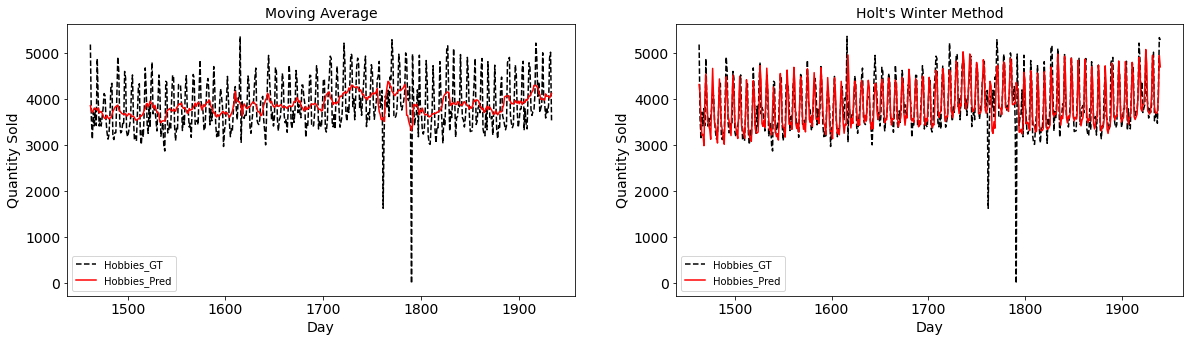

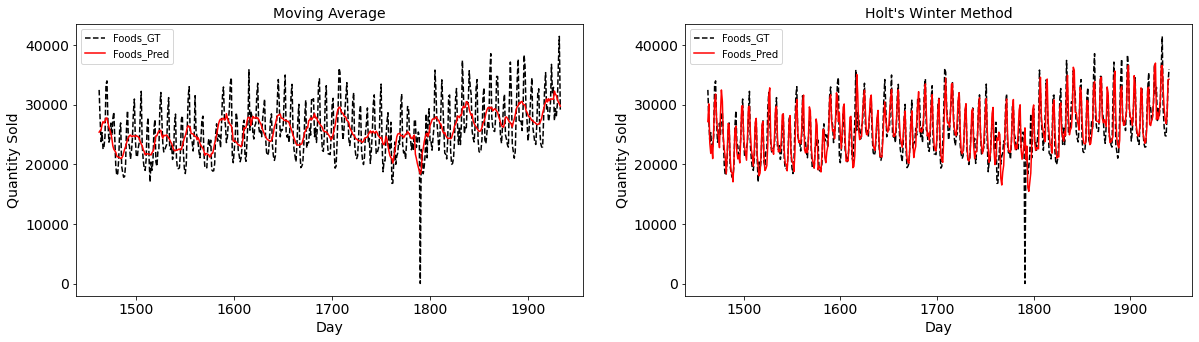

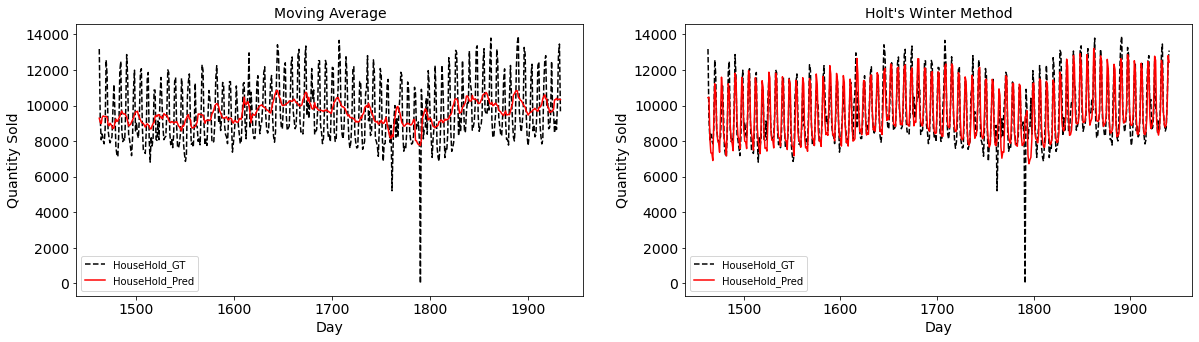

In [0]:
plot_statistical_models(TES_Hobbies_results, MA_Hobbies_results, 'day', 'Hobbies')
plot_statistical_models(TES_Foods_results, MA_Foods_results, 'day', 'Foods')
plot_statistical_models(TES_HouseHold_results, MA_HouseHold_results, 'day', 'HouseHold')

### ML Models
#### Feature Engineering

#####Feature Generation
- "no_of_events" - This column gives the total number of events for each day by summing the columns event_name_1 and 2
- More features are generated below

In [0]:
def feature_engineering(orig_df, ts_target_label, ts_index_label, categorical_labels, continuous_labels, lag_features, horizon):
  # Pre-checking df to find time series target, index and categorical and continuous variable names. Removing any columns that don't fit these descriptions
  orig_df = checking_df_inputs(orig_df, ts_target_label, ts_index_label, categorical_labels, continuous_labels)
  
  # Event column processing
  df = event_col_processing(orig_df)
  
  # One Hot Encoding Categorical features
  OHE_df = OHE(df, categorical_labels)
  
  # Applying lag depending on time horizon selected
  if horizon == 'day':
    horizon_df = apply_time_horizon(OHE_df,-1)
  elif horizon == 'week':
    horizon_df = apply_time_horizon(OHE_df,-7)
  elif horizon == 'month':
    horizon_df = apply_time_horizon(OHE_df,-28)
  
  # Creating time-series lag features
  lag_features_df = generate_lag_feat(orig_df, horizon_df, lag_features, column = 'ts_target', index = 'ts_index')
  
  # Preprocessing
  featurized_df, feature_Indexer = assemble_feature_indexer(lag_features_df)

  return featurized_df, feature_Indexer


In [0]:
def checking_df_inputs(df, ts_target_label, ts_index_label, categorical_labels, continuous_labels):
  columns = df.columns
  
  drop_columns = []
  for f in columns:
    if f not in categorical_labels and f not in continuous_labels and f != ts_target_label and f!= ts_index_label:
      drop_columns.append(f)
  
    df = df.drop(*drop_columns)
    df = df.withColumnRenamed(ts_target_label, 'ts_target').withColumnRenamed(ts_index_label, 'ts_index')
     
  return df
  

########################################Event Specific Functions##################################################
def event_col_processing(df):
  
  # Removing nulls in events columns
  df = removing_event_nulls(df)
  
  
  # Creating no_events feature
  event_1 = ['event_name_1', 'event_type_1']
  event_2 = ['event_name_2', 'event_type_2']

  breaker = False
  for e1 in event_1:
    for e2 in event_2:
      if e1 in df.columns and e2 in df.columns:
        df = create_no_events_feature(df, e1, e2)
        breaker = True
        break
    if breaker:
      break

  if breaker == False:
    print("WARNING: Need one of 'event_name_1', 'event_type_1' and one of 'event_name_2', 'event_type_2' to create no_events feature")
    
  return df


def removing_event_nulls(df):
  # Finding which event columns were inputed
  avail_events = [f for f in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'] if f in df.columns]
  
  # Changing null values to No event
  df = df.na.fill({event: 'No event' for event in avail_events})

  return df
  
  
def create_no_events_feature(df, e1, e2):
  
  def count_events(c1, c2):
    if c1 != "No event" and c2 != "No event":
      return 2
    elif c1 == "No event" and c2 != "No event":
      return 1
    elif c1 != "No event" and c2 == "No event":
      return 1
    else:
      return 0

  combineUDF = udf(count_events)
  expr = [c for c in df] + [combineUDF(e1, e2).alias("no_of_events").cast(DoubleType())]

  df = df.select(*expr)
  
  return df
###############################################################################################################

def OHE(cat_df, categorical_labels):
  #One Hot Encoding of categorical columns
  
  OHE_list = categorical_labels

  # Generate OHE for elements in the list above
  for element in OHE_list:

  #Convert String to Array so that OHE can run (requires an array as an input)
    cat_df = convert_col_to_array(cat_df, element + '_array', element,' ')

  #Initialize Count vectorizer
    elementVectorizer = initialize_Count_Vectorizer(element + '_array',element + '_OHE')

  #Fit a vectorizer model
    elementVectorizer_model = elementVectorizer.fit(cat_df)

  #Transform Data
    cat_df = elementVectorizer_model.transform(cat_df)

  #Specify Extraneous Cols to drop 
    columns_to_drop = [element, element + '_array']

  #Drop Extraneous Cols listed above
    cat_df = cat_df.drop(*columns_to_drop)
  
  return cat_df


# Function to apply a time horizon to a single column
def apply_time_horizon(input_df, lag):
  window = Window.orderBy("ts_index")
  output_df_name = input_df.withColumn("ts_target_lag", f.lag("ts_target",lag).over(window)).drop("ts_target")
  return output_df_name

  
# Function to create time-series lagged features  
def generate_lag_feat(orig_df, lag_df, lag_features, column = 'ts_target', index = 'ts_index'):
    window = Window.orderBy(index)
    
    lag_feature_df = orig_df.select('ts_index', 'ts_target')
    
    for lag_feature_val in lag_features:
      lag_feature_df = lag_feature_df.withColumn(f'Pre_d{lag_feature_val}',f.lag(col(column), lag_feature_val).over(window))
      
      
    output_df = lag_df.join(lag_feature_df, lag_feature_df.ts_index == lag_df.ts_index).drop(index)
    
    return output_df
  
  
####################
  
def assemble_feature_indexer(data):
  data = data.dropna()
  
  # Specify Input Columns that will become features in our final models
  featuresCols = data.columns
  featuresCols.remove('ts_target_lag')
  featuresCols.remove('ts_target')

  #Build Features using the feature assembler
  feature_assembler = VectorAssembler(inputCols = featuresCols, outputCol = "features")
  output = feature_assembler.transform(data) # Transform dataframe into features
  processed_data = output.select("features", 'ts_target_lag') # Generate final output two cols: one with features and the other with the target i.e Hobbies

  #Rename Hobbies Column to Hobbies_quantity to use with ML models in PySpark
  processed_data = processed_data.select(col("features"),col('ts_target_lag').alias('target'))

  #Build Feature Indexer:
  feature_Indexer = VectorIndexer(inputCol = 'features', outputCol = 'indexedFeatures',maxCategories = 15).fit(processed_data)

  processed_data = processed_data.select("*").withColumn("ts_index", monotonically_increasing_id())
  
  return processed_data, feature_Indexer

#### ML Model Development
###### Predicting over each category for the time horizons 1 day, 7 days and 28 days using the following algorithm
1. Gradient Boosting
2. Random Forest

NOTE : 
- The following set of code for each algorithm involves a increasing rolling window train test split with a split of 3
- Further Hyper parameter tuning is performed using Grid search and the parameters which give the least error value is chosen

In [0]:
def ml_model(orig_df, model_type = 'GBT', horizon = 'day', gridsearch_parameters = {'maxDepth': [5], 'maxIter': [10, 20]}, n_splits = 3, ts_target_label = 'Hobbies', ts_index_label = 'd', categorical_labels = ['wm_yr_wk', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], continuous_labels = [], lag_features = [1, 2, 3, 4, 5, 6, 7, 10, 14, 28], all_horizon = False, **modelargs):
  
  # Feature Engineering
  data, feature_Indexer = feature_engineering(orig_df, ts_target_label, ts_index_label, categorical_labels, continuous_labels, lag_features, horizon)
  
  
  df_header_list = ['Model', 'Horizon', 'Fold', list(gridsearch_parameters)[0], list(gridsearch_parameters)[1], 'r2', 'sMAPE', 'groundtruth', 'predictions']
  df_row_list = []
  
  # Creating datasets using k-folds generator
  k_folds_generator = get_kfolds_data(data, n_splits)
  
  # Applying grid search to data
  results = []
  fold_count = 1
  for train, test in k_folds_generator:
    # Gridsearch generator
      gridsearch_generator = get_gridsearch_parameters(model_type, gridsearch_parameters)

      for i, j in gridsearch_generator:
        model, predictions = apply_ml_model(train, test, results, model_type, feature_Indexer, i, j)
        
        # Incorporating Feature Importance
        predictions, regressor_type = apply_feature_importance(model, model_type, predictions, i, j)
        
        # Getting model performance 
        model_results = model_performance_metrics(predictions, regressor_type)
        
        # Collecting results
        df_row = [model_type, horizon, i, j, fold_count, *model_results]
        df_row_list.append(df_row)
      
      fold_count += 1
      
  results = [df_header_list, *df_row_list]
  
  # Converting model output into df
  df_results = model_postprocessing(results)
  
  return df_results, train

In [0]:
def get_kfolds_data(data, n_splits):
  
  # Converting from df to np-array
  data_as_nparray = np.array(data.select('features', 'target').collect(), dtype=object)
  
  splits = TimeSeriesSplit(n_splits = n_splits)
  
  for train_index, test_index in splits.split(data_as_nparray):
    train = data_as_nparray[train_index]
    test = data_as_nparray[test_index]
    train_df_pyspark = data.where(col('ts_index').between(0, len(train))).drop('ts_index')
    test_df_pyspark = data.where(col('ts_index').between(len(train)+1, len(train)+len(test))).drop('ts_index')
    
    yield train_df_pyspark, test_df_pyspark      
  
# Function that creates a generator object with the required gridsearch parameters
def get_gridsearch_parameters(model_type, gridsearch_parameters):
  
  if model_type == 'GBT':
    gridsearch_parameter1 = gridsearch_parameters['maxDepth']
    gridsearch_parameter2 = gridsearch_parameters['maxIter']
  elif model_type == 'RF':
    gridsearch_parameter1 = gridsearch_parameters['maxDepth']
    gridsearch_parameter2 = gridsearch_parameters['numTrees']
  
  for i in gridsearch_parameter1:
      for j in gridsearch_parameter2:
        yield i, j
        
# ML Model function that trains either the GBT or RF model and outputs the results of the model
def apply_ml_model(train, test, feature_list, model_type, feature_Indexer, i, j):
  
  # Model Selection and Creation
  if model_type == 'GBT':
    regressor_type = GBTRegressor(labelCol='target', maxDepth = i, maxIter = j)
  elif model_type == 'RF':
    regressor_type = RandomForestRegressor(labelCol='target', maxDepth = i, numTrees = j)
        
  pipeline = Pipeline(stages = [feature_Indexer, regressor_type])
  model = pipeline.fit(train)
  predictions = model.transform(test)
  
  return model, predictions


############## FEATURE IMPORTANCE FUNCTIONS ##########################

def apply_feature_importance(model, model_type, predictions, i, j):
   ## Extracting top 10 features
  varlist = get_feature_scorer_list(model.stages[-1].featureImportances, predictions, "features")
  varidx = [x for x in varlist['idx'][0:10]]
  slicer = VectorSlicer(inputCol = 'features', outputCol = 'new features', indices = varidx)
  new_df = slicer.transform(predictions)
  new_df = new_df.drop('rawPrediction', 'probability', 'prediction') 
  
  
  if model_type == 'GBT':
    regressor_type_2 = GBTRegressor(featuresCol = 'new features', labelCol='target', maxDepth = i, maxIter = j)
  elif model_type == 'RF':
    regressor_type_2 = RandomForestRegressor(featuresCol = 'new features', labelCol='target', maxDepth = i, numTrees = j)
  
  mod2 = regressor_type_2.fit(new_df)
  new_predictions = mod2.transform(new_df)
  
  return new_predictions, regressor_type_2


#user defined function to select important features. this takes in feature importance from a model and map it to column names
def get_feature_scorer_list(featureImp, dataset, featuresCol):
  
  list_extract = []
  for i in dataset.schema[featuresCol].metadata['ml_attr']['attrs']:
    list_extract = list_extract + dataset.schema[featuresCol].metadata['ml_attr']['attrs'][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return (varlist.sort_values('score', ascending = False))

  
################################################################

# A function that calculates model performance metrics
def model_performance_metrics(predictions, regressor_type):
  # Model Performance Metrics
  test_groundtruth = np.array(predictions.select('target').collect())
  test_predictions = np.array(predictions.select('prediction').collect())

  e = RegressionEvaluator(metricName="r2", labelCol=regressor_type.getLabelCol(), predictionCol=regressor_type.getPredictionCol())
  r2= e.evaluate(predictions)

  #Print sMAPE for the current regressor along with the regression model  
  s = smape(test_groundtruth,test_predictions)
  f = [r2,s, test_groundtruth, test_predictions]
  
  metrics = {'r2':r2, 'sMAPE': s}
  
  return f

# Creating a results df from model performance metrics
def model_postprocessing(results):
  
  full_df = pd.DataFrame(results[1:], columns = results[0])
  cross_average_df = full_df.groupby([full_df.columns[3], full_df.columns[4]], as_index=False).mean().drop(columns = 'Fold')
  best_model_df = cross_average_df[cross_average_df.sMAPE == cross_average_df.sMAPE.min()]
  
  results = {'full':full_df, 'cross_average':cross_average_df, 'best':best_model_df}
    
  return results

In [0]:
results, testdf = ml_model(df, model_type = 'GBT', horizon = 'week', gridsearch_parameters = {'maxDepth': [5], 'maxIter': [5, 15]})
results['full']

,Model,Horizon,Fold,maxDepth,maxIter,r2,sMAPE,groundtruth,predictions
0,GBT,week,5,5,1,0.775537,8.717523,"[[2737.0], [2527.0], [2468.0], [3434.0], [3985...","[[2517.4423739762588], [2516.477365320129], [2..."
1,GBT,week,5,15,1,0.881484,6.745862,"[[2737.0], [2527.0], [2468.0], [3434.0], [3985...","[[2507.8327060263614], [2567.125724263506], [2..."
2,GBT,week,5,5,2,0.746168,6.964662,"[[2892.0], [3262.0], [3152.0], [3756.0], [4242...","[[3106.391809754532], [2970.2251284222502], [3..."
3,GBT,week,5,15,2,0.869026,5.055574,"[[2892.0], [3262.0], [3152.0], [3756.0], [4242...","[[2968.801959589581], [3105.6919676048055], [3..."
4,GBT,week,5,5,3,0.770698,5.853061,"[[3716.0], [3419.0], [3795.0], [3427.0], [4878...","[[3492.212895252089], [3492.212895252089], [34..."
5,GBT,week,5,15,3,0.877864,4.495503,"[[3716.0], [3419.0], [3795.0], [3427.0], [4878...","[[3596.1011422374354], [3479.12134627964], [36..."


In [0]:
display(testdf)

features,target
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 282, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2675.0, 2559.0, 2758.0, 2459.0, 2735.0, 2978.0, 4142.0, 2170.0, 3699.0, 3764.0))",2096.0
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 282, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4088.0, 2675.0, 2559.0, 2758.0, 2459.0, 2735.0, 2978.0, 2049.0, 3417.0, 3357.0))",3795.0
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 282, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2118.0, 4088.0, 2675.0, 2559.0, 2758.0, 2459.0, 2735.0, 2284.0, 2233.0, 2682.0))",2687.0
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1771.0, 2118.0, 4088.0, 2675.0, 2559.0, 2758.0, 2459.0, 4142.0, 2554.0, 2669.0))",2519.0
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1833.0, 1771.0, 2118.0, 4088.0, 2675.0, 2559.0, 2758.0, 2978.0, 2170.0, 1814.0))",2955.0
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1675.0, 1833.0, 1771.0, 2118.0, 4088.0, 2675.0, 2559.0, 2735.0, 2049.0, 3220.0))",2686.0
"Map(vectorType -> sparse, length -> 364, indices -> List(228, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1855.0, 1675.0, 1833.0, 1771.0, 2118.0, 4088.0, 2675.0, 2459.0, 2284.0, 2944.0))",2688.0
"Map(vectorType -> sparse, length -> 364, indices -> List(64, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1653.0, 1855.0, 1675.0, 1833.0, 1771.0, 2118.0, 4088.0, 2758.0, 4142.0, 3986.0))",3630.0
"Map(vectorType -> sparse, length -> 364, indices -> List(64, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2096.0, 1653.0, 1855.0, 1675.0, 1833.0, 1771.0, 2118.0, 2559.0, 2978.0, 2899.0))",3282.0
"Map(vectorType -> sparse, length -> 364, indices -> List(64, 279, 295, 297, 298, 335, 336, 341, 342, 350, 351, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3795.0, 2096.0, 1653.0, 1855.0, 1675.0, 1833.0, 1771.0, 2675.0, 2735.0, 2615.0))",2500.0


In [0]:
test = smape(results['full']['groundtruth'][0], results['full']['predictions'][0])
print(test)

8.717523375220617


In [0]:
results['cross_average']

,maxDepth,maxIter,r2,sMAPE
0,5,1,0.775537,8.717523
1,5,2,0.746168,6.964662
2,5,3,0.770698,5.853061
3,15,1,0.881484,6.745862
4,15,2,0.869026,5.055574
5,15,3,0.877864,4.495503


In [0]:
results['best']

,maxDepth,maxIter,r2,sMAPE
5,15,3,0.877864,4.495503


In [0]:
gt = [*results['full']['groundtruth'][0]]
gt

Out[33]: [array([2737.]),
 array([2527.]),
 array([2468.]),
 array([3434.]),
 array([3985.]),
 array([2636.]),
 array([2314.]),
 array([2414.]),
 array([1930.]),
 array([2081.]),
 array([2638.]),
 array([2677.]),
 array([3367.]),
 array([2647.]),
 array([2630.]),
 array([2711.]),
 array([2567.]),
 array([3300.]),
 array([3692.]),
 array([3216.]),
 array([2868.]),
 array([2596.]),
 array([2661.]),
 array([3137.]),
 array([3405.]),
 array([3593.]),
 array([3390.]),
 array([2735.]),
 array([2301.]),
 array([2126.]),
 array([2277.]),
 array([2457.]),
 array([2783.]),
 array([2444.]),
 array([2094.]),
 array([2353.]),
 array([2563.]),
 array([2604.]),
 array([2833.]),
 array([2810.]),
 array([2629.]),
 array([2268.]),
 array([2166.]),
 array([2023.]),
 array([2007.]),
 array([2445.]),
 array([2716.]),
 array([2647.]),
 array([2055.]),
 array([2075.]),
 array([2254.]),
 array([2452.]),
 array([2490.]),
 array([2885.]),
 array([2912.]),
 array([2071.]),
 array([1954.]),
 array([2203.]),
 arra

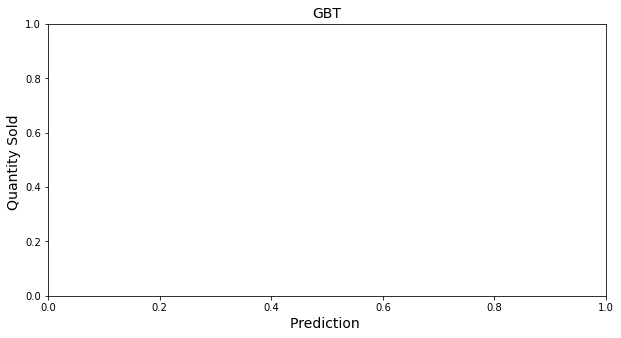

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-71585235484457> in <module>
      5 axes.set_ylabel('Quantity Sold ', fontsize = f_size)
      6 
----> 7 plt.plot(results['full']['groundtruth'][0], ax=axes, color=['Black', 'Red'],  style= ['--', '-'], fontsize = f_size)
      8 plt.plot()
      9 

/databricks/python/lib/python3.8/site-packages/matplotlib/pyplot.py in plot(scalex, scaley, data, *args, **kwargs)
   3017 @_copy_docstring_and_deprecators(Axes.plot)
   3018 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):
-> 3019     return gca().plot(
   3020         *args, scalex=scalex, scaley=scaley,
   3021         **({"data": data} if data is not None else {}), **kwargs)

/databricks/python/lib/python3.8/site-packages/matplotlib/axes/_axes.py in plot(self, scalex, scaley, data, *args, **kwargs)
   1603         """
   1604         kwargs = cbook.normalize_kwa

In [0]:
f_size = 14 # Font Size
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10 ,5));
axes.set_title("GBT", fontsize = f_size)
axes.set_xlabel('Prediction ', fontsize = f_size)
axes.set_ylabel('Quantity Sold ', fontsize = f_size)

plt.plot(results['full']['groundtruth'][0], ax=axes, color=['Black', 'Red'],  style= ['--', '-'], fontsize = f_size)
plt.plot()

plt.show() 